# How SR3 super-resolution model works

## Table of Contents

* [Introduction](#Introduction)
* [Prepare training data](#Prepare-training-data)
* [SR3's approch to super-resolution](#SR3's-approch-to-super-resolution)
* [Architecture](#Architecture)
* [Implementation in arcgis.learn](#Implementation-in-arcgis.learn) 
* [Inferencing in ArcGIS Pro](#Inferencing-in-ArcGIS-Pro)
* [References](#References)

## Introduction

High resolution imagery is desirable for both visualization and image interpretation. However, high resolution imagery is expensive to procure. This sample notebook demonstrates how the `sr3` model in `SuperResolution` class in `arcgis.learn` module can be used to increase image resolution. This model uses deep learning to add texture and detail to low resolution satellite imagery and turn it into higher resolution imagery.

We first start with high resolution aerial imagery to train the model. The data preparation step first downsamples the higher resolution imagery to create lower resolution uisng bi-cubic interpolation. The SuperResolution model uses this training data and learns how to upsample the lower resolution imagery and produce realistic high resolution images that closely resemble the higher quality images that we started with. We then use the trained `sr3` model to produce simulated high resolution aerial imagery from relatively lower resolution satellite imagery.

In this guide, we will focus on the `SR3`, an image super-resolution technique based on denoising diffusion probabilistic models (ddpm), originally developed by [Saharia et al.](https://arxiv.org/pdf/2104.07636) 

## Prepare training data

The [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool with `Export Tiles` metadata format, is used to export training data for the model. There are two cases, 
* If a pair of high resolution (hr) and its corresponding low resolution (lr) imagery is available. The hr is provided in input imagery and lr is provided in additional raster.
* And, If only high resolution (hr) is available. The hr is provided in input imagery, during `prepare_data` low res samples are generated based on the provided downsampling factor. 

## SR3's approch to super-resolution

Recent advances in generative modeling have introduced diffusion models, which have demonstrated better performance compared to earlier approaches. `SR3` or `Super-Resolution via Repeated Refinement` adapts [denoising diffusion probabilistic model (DDPM)](https://arxiv.org/abs/2006.11239) for conditional image generation and performs super-resolution through a stochastic denoising process as shown in figure 1. During inferencing, a [U-Net](https://arxiv.org/abs/1505.04597) model trained on denoising at various noise levels is used to to iteratively refine noisy output. Learning by denoising consists of two processes, each of which is a Markov Chain. As shown in figure below, These are:

1. The forward process - In the [forward markovian diffusion process](https://math.nyu.edu/~goodman/teaching/StochCalc2018/notes/Lesson2.pdf), it gradually adds Gaussian noise to a high-resolution or target image over T iterations.


2. The reverse process - The reverse inference process, it iteratively denoises the target image conditioned on a source image or low-resolution image.

We learn the reverse chain using a neural denoising model or UNet that takes as input a source image and a noisy target image and aims to recover or estimate noisless target image. The noisy target image is similar to the distribution of noisy images generated at different steps of the forward diffusion process.

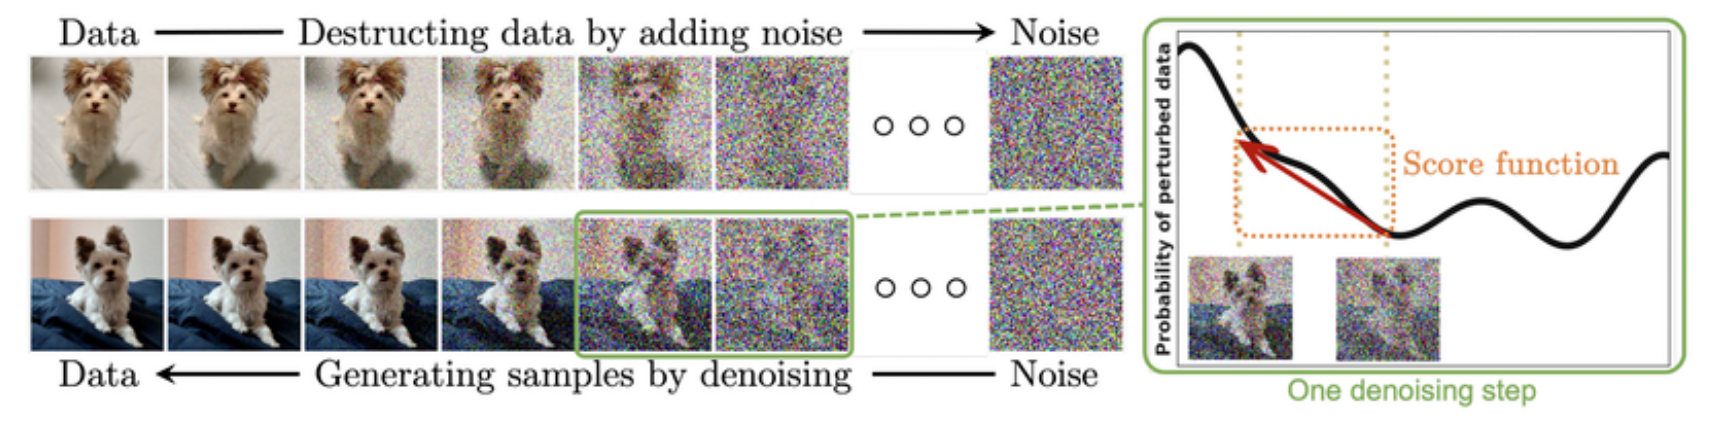

<center>
    <figcaption>Figure 1. Diffusion models smoothly perturb data by adding noise, then reverse this process to generate new data from noise. Each denoising step in the reverse process typically requires estimating the score function.  </figcaption>
    </center>

### Architecture

The SR3 architecture is similar to the U-Net found in [DDPM](https://arxiv.org/abs/2006.11239) with group normalization throughout. The original DDPM residual blocks were replaced with residual blocks from [BigGAN](https://arxiv.org/abs/1809.11096), and the skip connections were re-scaled by 1/√2. The the number of residual blocks, and the channel multipliers at different resolutions are also increased as described in the paper and also shown below. 

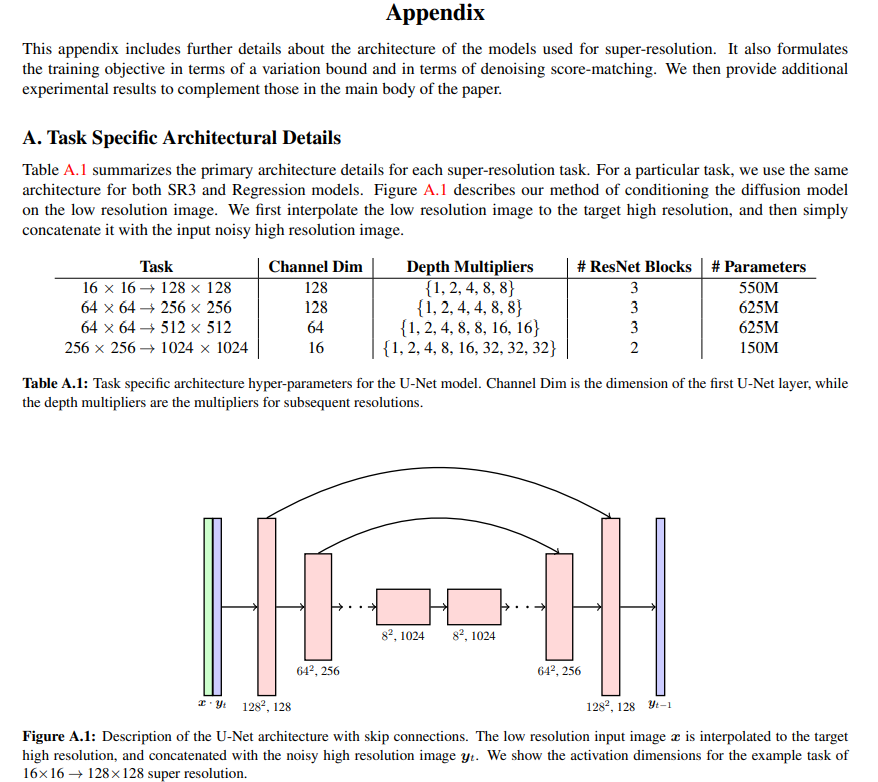

<center>
    <figcaption>Figure 2. Channel dimensions, depth multipliers, number of resnet blocks for various tasks.  </figcaption>
    </center>

For further detailed information on the model's architecture and working, refer to the [paper](https://arxiv.org/abs/2104.07636).

## Implementation in `arcgis.learn`

Export - use the input raster  to export the raster chips in `Export tiles` metadata format using [Export Training Data for Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool available in `ArcGIS Pro`. The resulting path from export tool is provided to [prepare_data](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#prepare-data) function in `arcgis.learn` to create a databunch.

`data = prepare_data(path=r"path/to/exported/data", batch_size=4)`

To initialize the `SuperResolution` object with `SR3` model_type is shown below:

`model = arcgis.learn.SuperResolution(data, model_type="SR3")`
                            
model parameters that can be passed using keyword arguments:

* `inner_channel` - Optional integer. inner_channel is the dimension of the first unet layer. default set to `64`.
* `norm_groups` - Optional integer. number of groups for group normalization. default set to `32`.
* `channel_mults` - Optional list. depth multipliers are the multipliers for subsequent resolutions in the unet. default set to `[1, 2, 4, 4, 8, 8]`.
* `attn_res` - Optional integer. number of attentions in residual blocks. default set to `16`.
* `res_blocks` - Optional integer. number of residual blocks. default set to `3`.
* `dropout` - Optional float. dropout. default set to `0`.
* `schedule` - Optional string. type of schedule. Available are 'linear', 'warmup10', 'warmup50', 'const', 'jsd', 'cosine'. Default set to `'linear'`.
* `n_timestep` - Optional list. number of diffusion timesteps.default set to `1500`.
* `linear_start` - Optional integer. schedule start. default set to `1e-05`.
* `linear_end` - Optional integer. schedule end. default set to `1e-02`.

#### recommendations:
- Default values are set for 64 -> 256 upscale tasks. for landsat/sentinel or coarser resolution tasks, values from 64 -> 512 task gives better results.
- Number of res blocks can be decreased if 'out-of-memory' issue is encountered. 
- Optimal results are generally obtained, if trained for atleast 200-300 epochs provided there is adequate amount of data.
- Its observed that larger norm_groups often cause hue deviation, decreasing often fixes the issue. 

Here, `data` is the object returned from `prepare_data` function. 

Once the model is initialized, the training process begins with model.`fit()` using a learning rate of 1e-05 until the model produces stable results. If the `tensorboard` model argument is enabled, it allows for real-time monitoring of the model's generation progress during training.

For more information about the API, please go through the [API reference](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html).

## Inferencing in `ArcGIS Pro`

The `Classify Pixels Using Deep Learning` tool in ArcGIS Pro is used for inferencing on low resolution imagery using the saved model. 
During inference, the model utilizes the follwing major arguments:
- `sampling_type` - type of sampling. Two type of sampling can be used. 'ddim' and 'ddpm'. 'ddim' is set as default as its generates in much less timesteps compared to ddpm. 
- `schedule` - default set to the schedule the model is trained on.
- `n_timestep` - default is set to 200. It can be increased and decreased based on the quality of generations. If ddpm sampling_type is used, it is to be set to 1500. It may take significant greater time for generation.

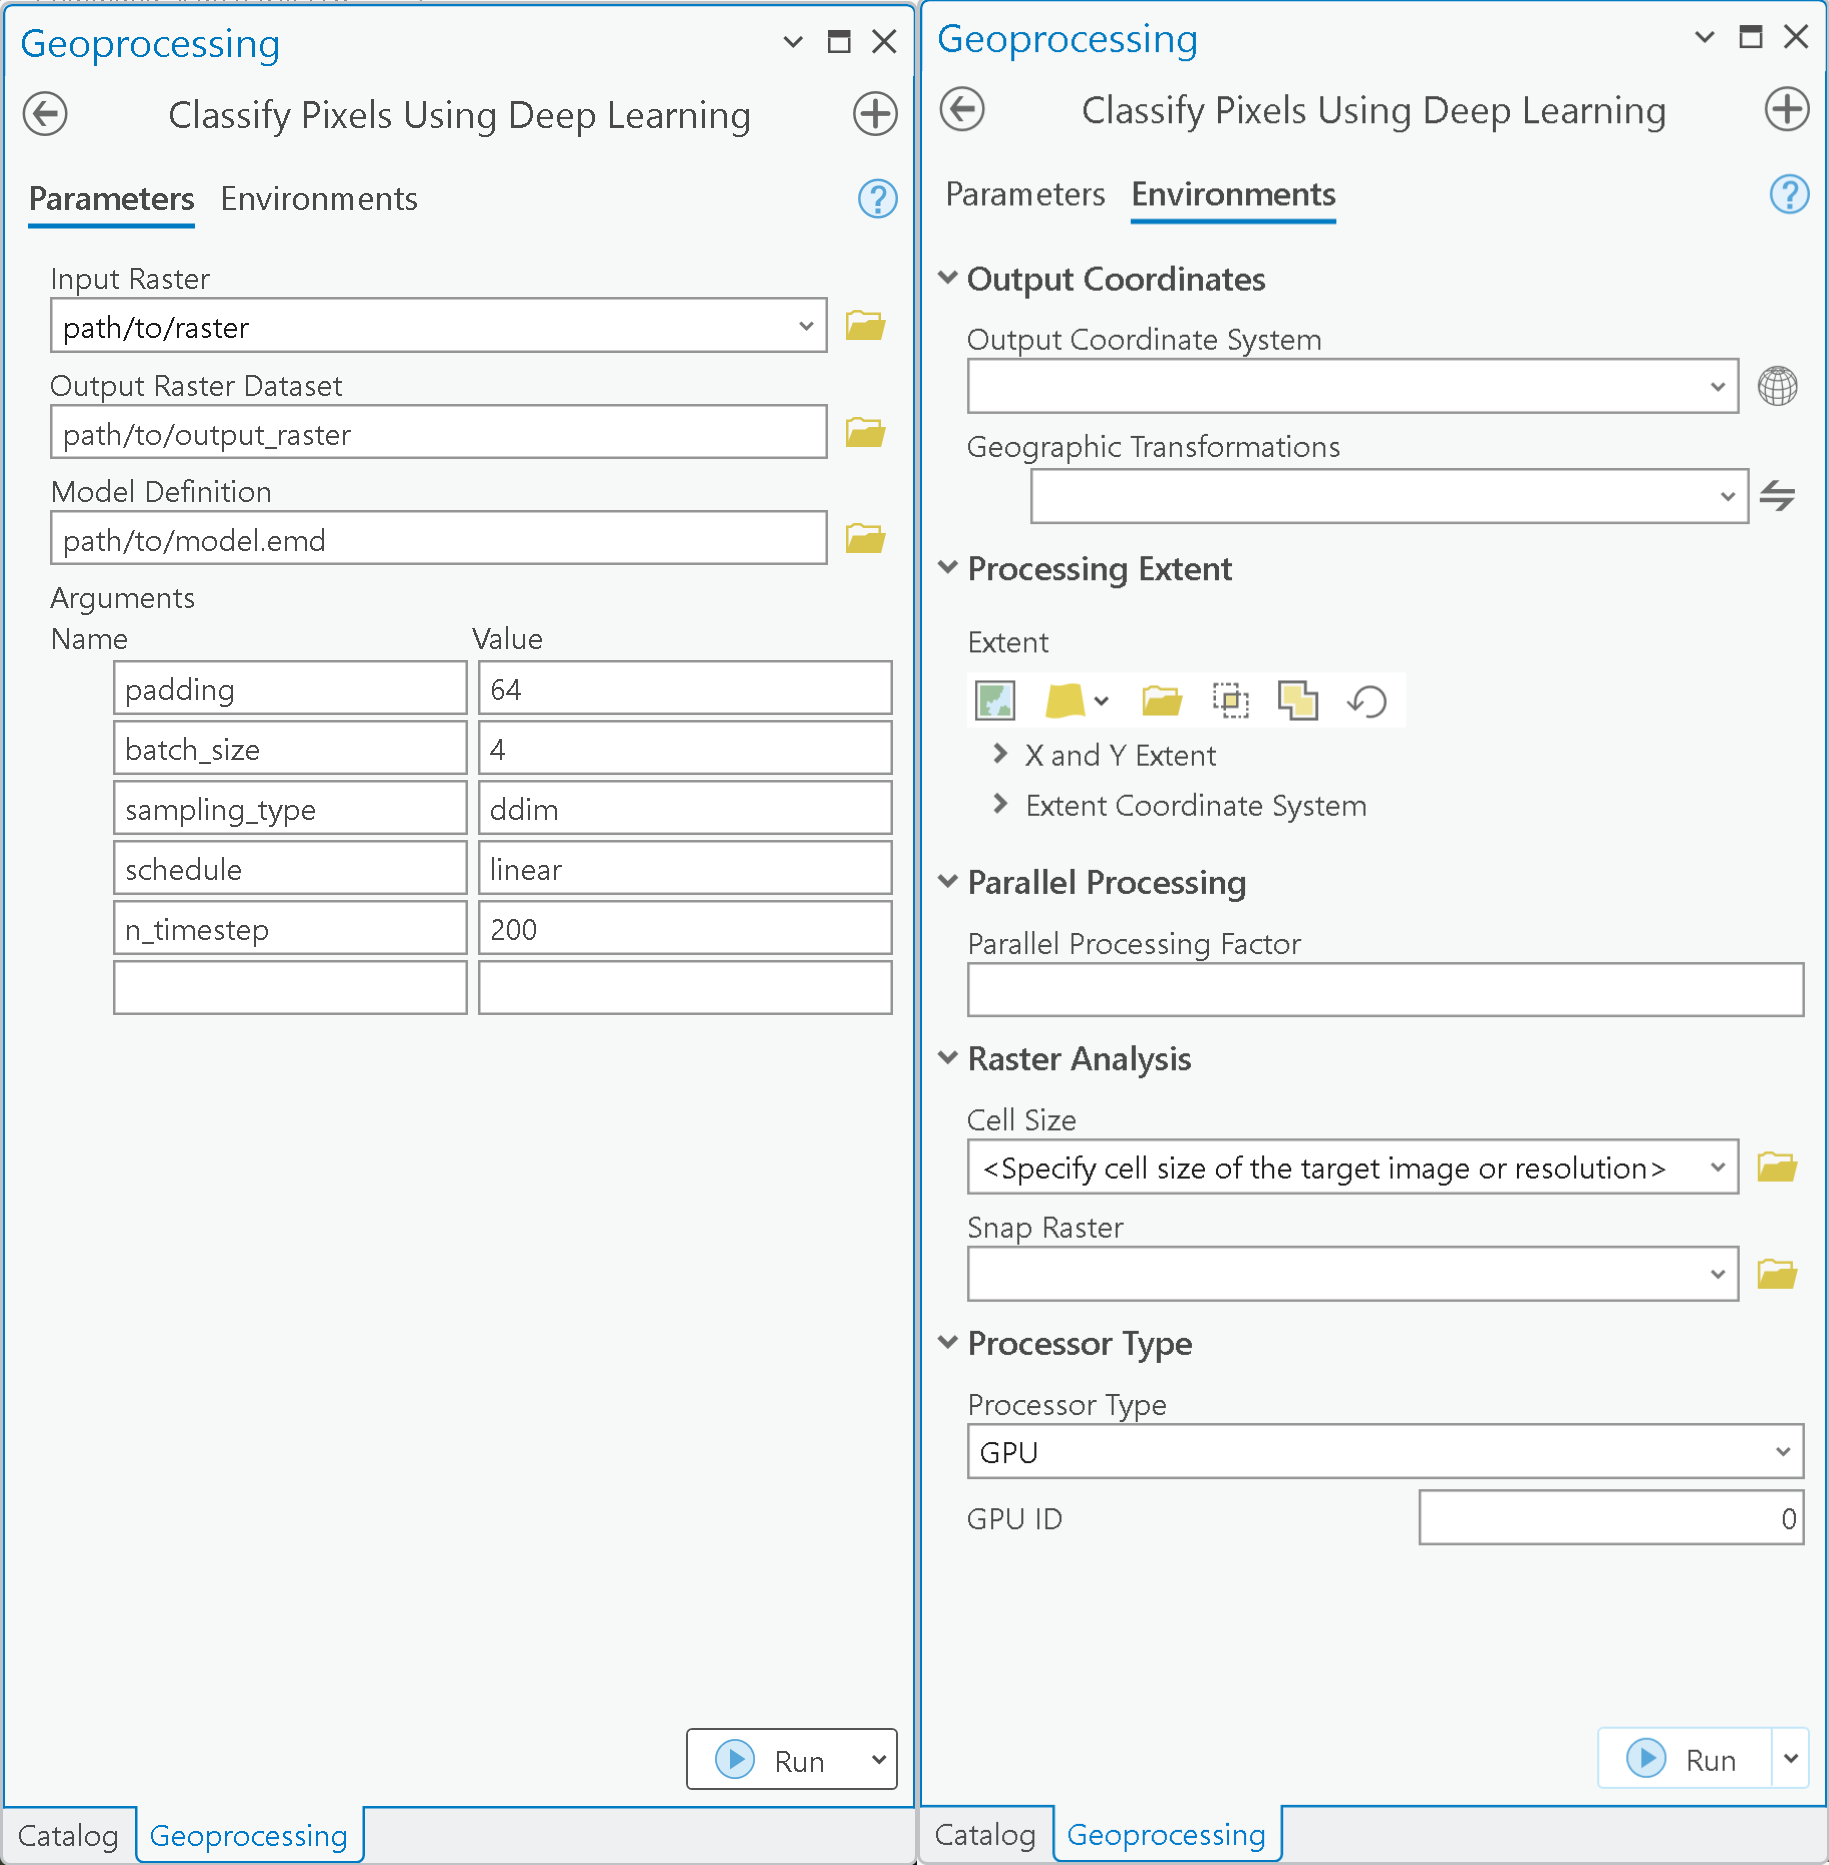

## References

- Saharia, Chitwan, Jonathan Ho, William Chan, Tim Salimans, David J. Fleet, and Mohammad Norouzi. "Image super-resolution via iterative refinement." IEEE Transactions on Pattern Analysis and Machine Intelligence 45, no. 4 (2022): 4713-4726.
- Ho, Jonathan, Ajay Jain, and Pieter Abbeel. "Denoising diffusion probabilistic models." Advances in neural information processing systems 33 (2020): 6840-6851.